In [ ]:
# ============================================================
# INSTALACIÓN + IMPORTS
# ============================================================
!pip install -q intake intake-esm xarray netcdf4 zarr cartopy shapely pyproj fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp

import intake
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.dpi"] = 120

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 4.0 MB

In [ ]:
# ============================================================
# DEFINIR DOMINIO COMÚN + PERIODO CLIMATOLÓGICO (1981–2010)
# ============================================================

# Dominio común "Piura ampliado" (como tu ejemplo)
#DOMINIO = dict(
#    lat=slice(-8.5, -2.2),
#    lon=slice(-81.5, -77.5)
#)

# Dominio común "Ayacucho" (como tu ejemplo)
#DOMINIO = dict(
#    lat=slice(-15.5, -11.5),
#    lon=slice(-76.5, -70.5)
#)

# Dominio común "Region Centro" (como tu ejemplo)
DOMINIO = dict(
    lat=slice(-13.5, -10.0),
    lon=slice(-77.5, -68.5)
)

# Periodo climatológico base
PERIODO_CLIM = slice("1981-01", "2010-12")

# Punto para serie temporal (xx) para ver si los datos corren correctamente
#para realizar la serie
LAT_PTO = -12.5
LON_PTO = -70.1

# Fecha de ejemplo para mapas
FECHA_EJEMPLO = "1990-01"

LAT_MIN = DOMINIO["lat"].start
LAT_MAX = DOMINIO["lat"].stop
LON_MIN = DOMINIO["lon"].start
LON_MAX = DOMINIO["lon"].stop

proj = ccrs.PlateCarree()

In [ ]:
# ============================================================
# FUNCIONES ÚTILES
# ============================================================
# Se transforman las coordendas como lat y lon

def fix_lon_cmip(ds):
    """0–360 -> -180–180 para CMIP6"""
    if "lon" in ds.coords:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180).sortby("lon")
    return ds

def fix_lon_era(ds):
    """0–360 -> -180–180 para ERA5 (longitude)"""
    if "longitude" in ds.coords:
        ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360) - 180).sortby("longitude")
    return ds

def squeeze_cmip_da(da):
    """
    Quita dims extra típicas de CMIP6 si existen
    (member_id, dcpp_init_year, etc.) tomando el índice 0.
    """
    for d in ["member_id", "dcpp_init_year", "variant_label", "realization", "init_year"]:
        if d in da.dims:
            da = da.isel({d: 0})
    return da.squeeze()

def plot_map_pr(da2d, title):
    """Mapa simple de precipitación mensual (2D lat-lon)."""
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=proj)
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=proj)

    #ax.set_extent(extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da2d.lon,
        da2d.lat,
        da2d.values,
        cmap="Blues",
        shading="auto",
        transform=proj,
        vmin=0,
        vmax=650
    )

    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Precipitación (mm/mes)")
    cbar.set_ticks(np.arange(0, 651, 50))

    ax.set_title(title, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# ============================================================
# Importar el shape del area de estudio
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd

ruta = "/content/drive/MyDrive/Colab Notebooks/Junin.shp/Junin.shp"
gdf = gpd.read_file(ruta)

gdf.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,IDDPTO,NOMBDPTO,CAPITAL,disolve,Shape_Leng,Shape_Area,geometry
0,12,JUNIN,HUANCAYO,1,14.155819,3.648829,"POLYGON ((-75.03709 -10.68116, -75.03418 -10.6..."


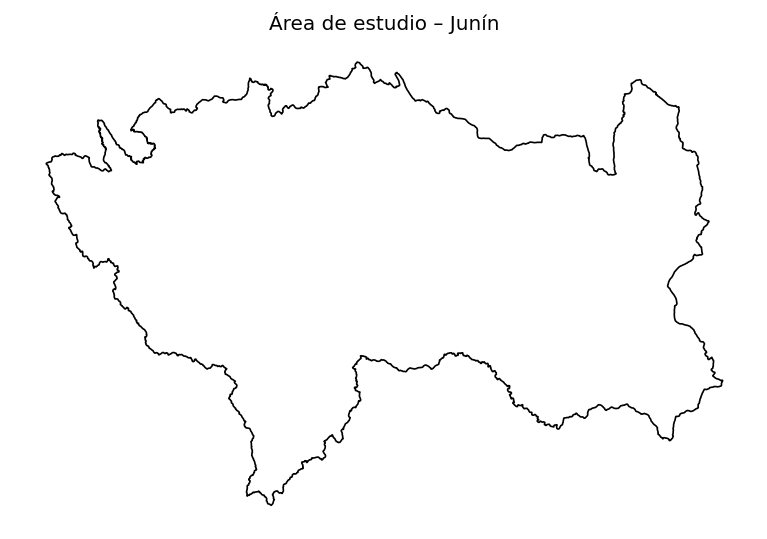

In [ ]:
##import matplotlib.pyplot as plt

#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#gdf.plot(ax=ax, edgecolor="black", color="white")
#ax.set_title("Área de estudio – Junín")
#ax.axis("off")
#plt.show()



Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado
  dims plot: ('lat', 'lon'), shape=(3, 5)


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


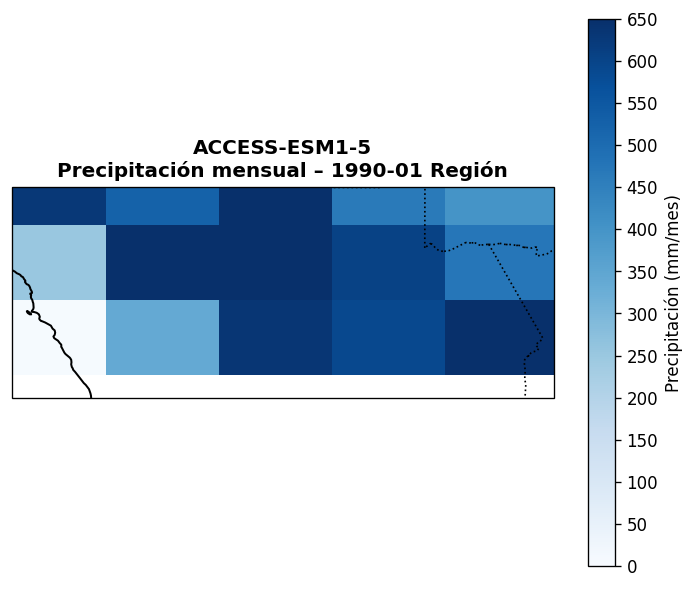


Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado
  dims plot: ('lat', 'lon'), shape=(3, 8)


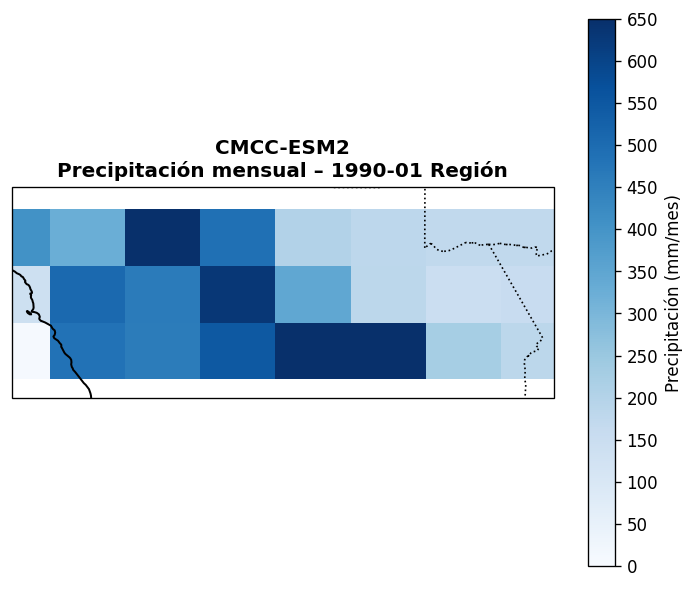


Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado
  dims plot: ('lat', 'lon'), shape=(3, 7)


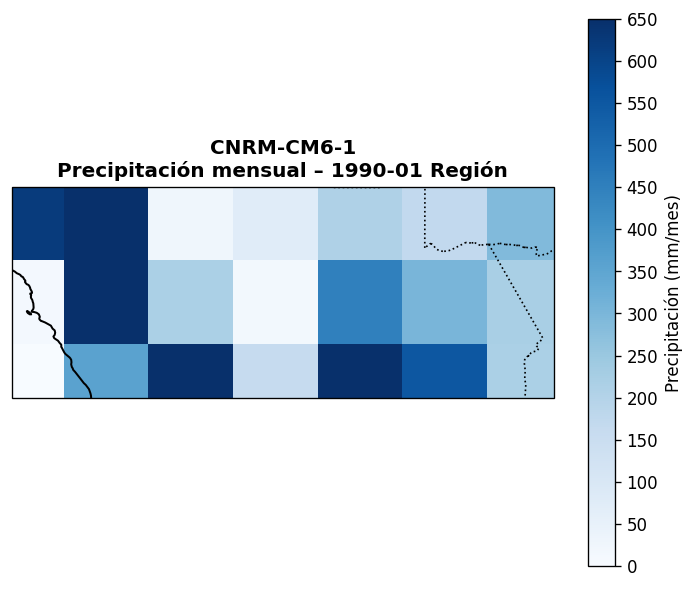


Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado
  dims plot: ('lat', 'lon'), shape=(3, 8)


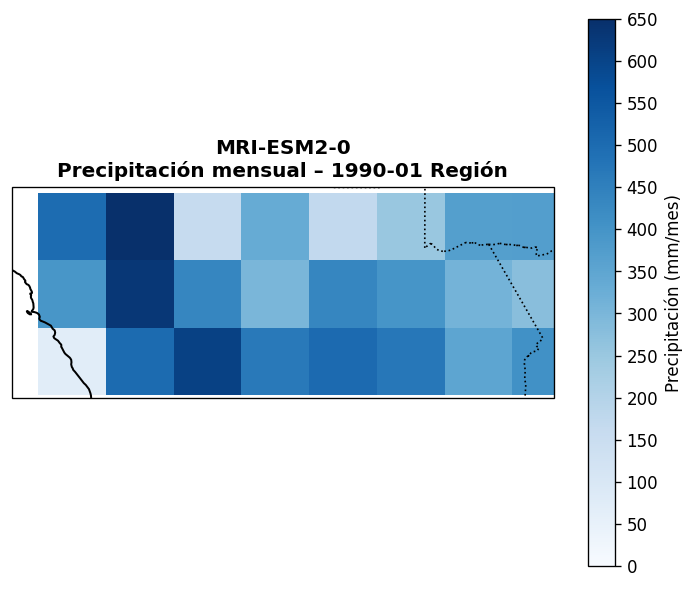


Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado
  dims plot: ('lat', 'lon'), shape=(3, 8)


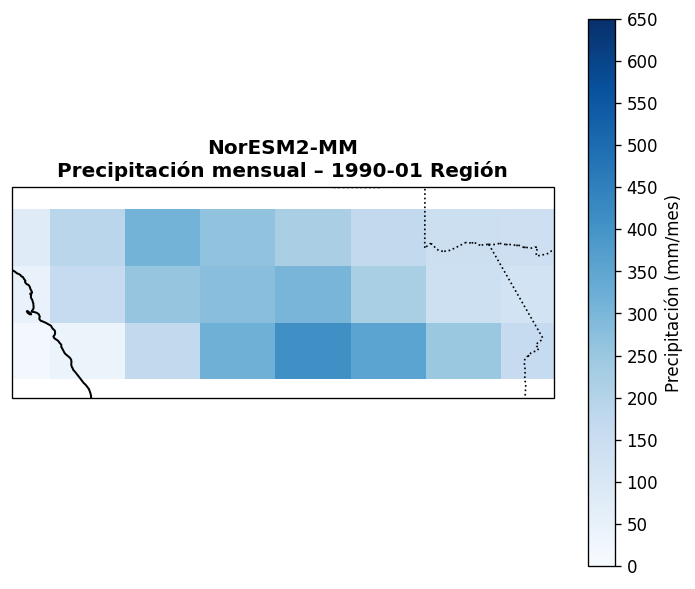

In [ ]:
# ============================================================
# LEER 5 MODELOS CMIP6 MENSUAL (pr), DEFINIR VARIABLE POR MODELO
# ============================================================
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2", # Este modelo no tiene forzamiento 2
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

datasets = {}
pr_por_modelo = {}   # aquí guardaremos pr mensual (mm/mes) por modelo

for modelo, member in MODELOS.items():
    print(f"\nAbriendo {modelo} ({member})...")

    cat_tmp = cat.search(
        activity_id="CMIP",
        source_id=modelo,
        experiment_id="historical", # Se define que se quiere leer lo historico
        table_id="Amon",
        variable_id="pr",
        member_id=member
    )

    if len(cat_tmp.df) == 0:
        print(f"  ❌ {modelo}: no disponible en este filtro")
        continue

    ds_dict = cat_tmp.to_dataset_dict(
        zarr_kwargs={"consolidated": False},
        storage_options={"token": "anon"},
        xarray_open_kwargs={"use_cftime": True}
    )

    ds = list(ds_dict.values())[0]
    ds = fix_lon_cmip(ds)
    datasets[modelo] = ds
    print(f"  ✅ {modelo} cargado")

#Considerar los cambio de unidades, como el CMIP 6
    # ---- pr mensual mm/mes para TODOS
    days_in_month = ds.time.dt.days_in_month
    pr_modelo = ds["pr"] * 86400 * days_in_month
    pr_modelo.attrs["units"] = "mm/mes"

    pr_por_modelo[modelo] = pr_modelo

    # ---- mapa ejemplo ----
    pr_area = pr_modelo.sel(**DOMINIO)
    pr_plot = pr_area.sel(time=FECHA_EJEMPLO)
    pr_plot = squeeze_cmip_da(pr_plot)


    # verificación dims
    print(f"  dims plot: {pr_plot.dims}, shape={pr_plot.shape}")

    plot_map_pr(
        pr_plot,
        title=f"{modelo}\nPrecipitación mensual – {FECHA_EJEMPLO} Región"
    )

In [ ]:
!pip install rioxarray geopandas shapely fiona pyproj


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import rioxarray

# Cargar shapefile
ruta_shape = "/content/drive/MyDrive/Colab Notebooks/Junin.shp/Junin.shp"
gdf = gpd.read_file(ruta_shape).to_crs(epsg=4326)

# Asignar CRS al DataArray CMIP6 #CMIP6 NO viene con CRS definido, hay que asignarlo
pr_modelo = pr_modelo.rio.write_crs("EPSG:4326", inplace=False)

# Clip espacial
pr_clip = pr_modelo.rio.clip(
    gdf.geometry,
    gdf.crs,
    drop=True
)



In [ ]:
##Cortar el área usando el shapefile

#Aplica el clip después de convertir a mm/mes:

# ---- pr mensual mm/mes ----
days_in_month = ds.time.dt.days_in_month
pr_modelo = ds["pr"] * 86400 * days_in_month
pr_modelo.attrs["units"] = "mm/mes"

# Asignar CRS
pr_modelo = pr_modelo.rio.write_crs("EPSG:4326", inplace=False)

# CLIP espacial con Junín
pr_clip = pr_modelo.rio.clip(
    gdf.geometry,
    gdf.crs,
    drop=True
)


dims plot: ('lat', 'lon'), shape=(2, 2)


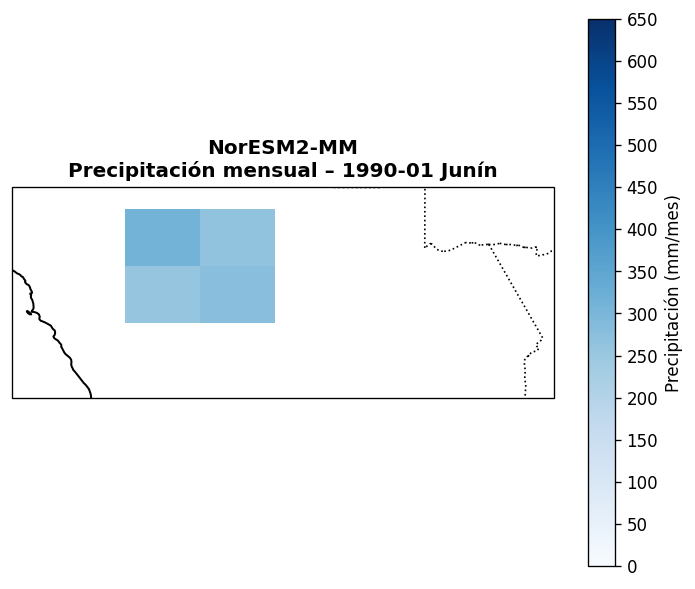

In [ ]:
pr_plot = pr_clip.sel(time=FECHA_EJEMPLO)
pr_plot = squeeze_cmip_da(pr_plot)

print(f"dims plot: {pr_plot.dims}, shape={pr_plot.shape}")

plot_map_pr(
    pr_plot,
    title=f"{modelo}\nPrecipitación mensual – {FECHA_EJEMPLO} Junín"
)


In [ ]:
#LEER ERA5

In [ ]:
!pip install -q xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp > /dev/null 2>&1
!apt-get install -qq -y libproj-dev proj-data proj-bin libgeos-dev > /dev/null 2>&1
!pip install -q cartopy shapely pyproj > /dev/null 2>&1

In [ ]:
import xarray as xr
xr.backends.list_engines()

{'netcdf4': <NetCDF4BackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html,
 'h5netcdf': <H5netcdfBackendEntrypoint>
   Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html,
 'scipy': <ScipyBackendEntrypoint>
   Open netCDF files (.nc, .cdf and .nc.gz) using scipy in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html,
 'kerchunk': <KerchunkBackend>
   Open Kerchunk References with Xarray
   Learn more at https://fsspec.github.io/kerchunk/,
 'pydap': <PydapBackendEntrypoint>
   Open remote datasets via OPeNDAP using pydap in Xarray
   Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.PydapBackendEntrypoint.html,
 'store': <S

In [ ]:
#Usar token registrado
# Piden Token porque los daris estan en formato ZARR
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Permisos
!chmod 600 /root/.netrc


Abriendo ERA5 mensual...
ERA5 area shape: (1031, 15, 37)


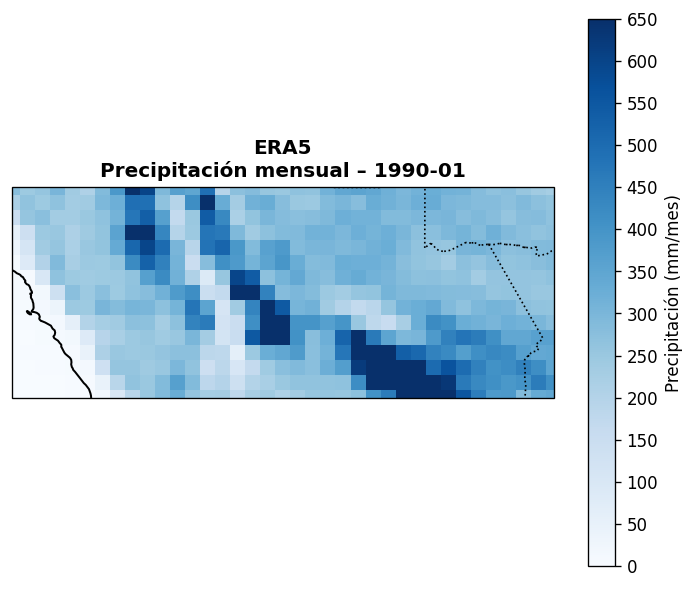

In [ ]:
# ============================================================
# 3) ERA5 – LECTURA + MAPA EJEMPLO (CORREGIDO)
# ============================================================
#Se ve mas refinado porque la resolucion es 25 km
print("\nAbriendo ERA5 mensual...")

era = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr",
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

era = fix_lon_era(era)
era = era.sortby("latitude")
era = era.sortby("longitude")

fechas = pd.to_datetime(era.valid_time.values)
dias_mes = xr.DataArray(
    fechas.days_in_month,
    coords={"valid_time": era.valid_time},
    dims=["valid_time"]
)

pr_era5_all = era.tp * 1000 * dias_mes #Conversion de unidades
pr_era5_all.attrs["units"] = "mm/mes"

pr_era5_area = pr_era5_all.sel(
    latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
    longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop)
)

print("ERA5 area shape:", pr_era5_area.shape)

pr_era5_plot = (
    pr_era5_area
    .sel(valid_time=FECHA_EJEMPLO)
    .squeeze()
    .rename({"latitude": "lat", "longitude": "lon"})
)

plot_map_pr(
    pr_era5_plot,
    f"ERA5\nPrecipitación mensual – {FECHA_EJEMPLO}" #Fecha definida de ejemplo
)

Meses comunes: 360
Inicio: 198101 Fin: 201012


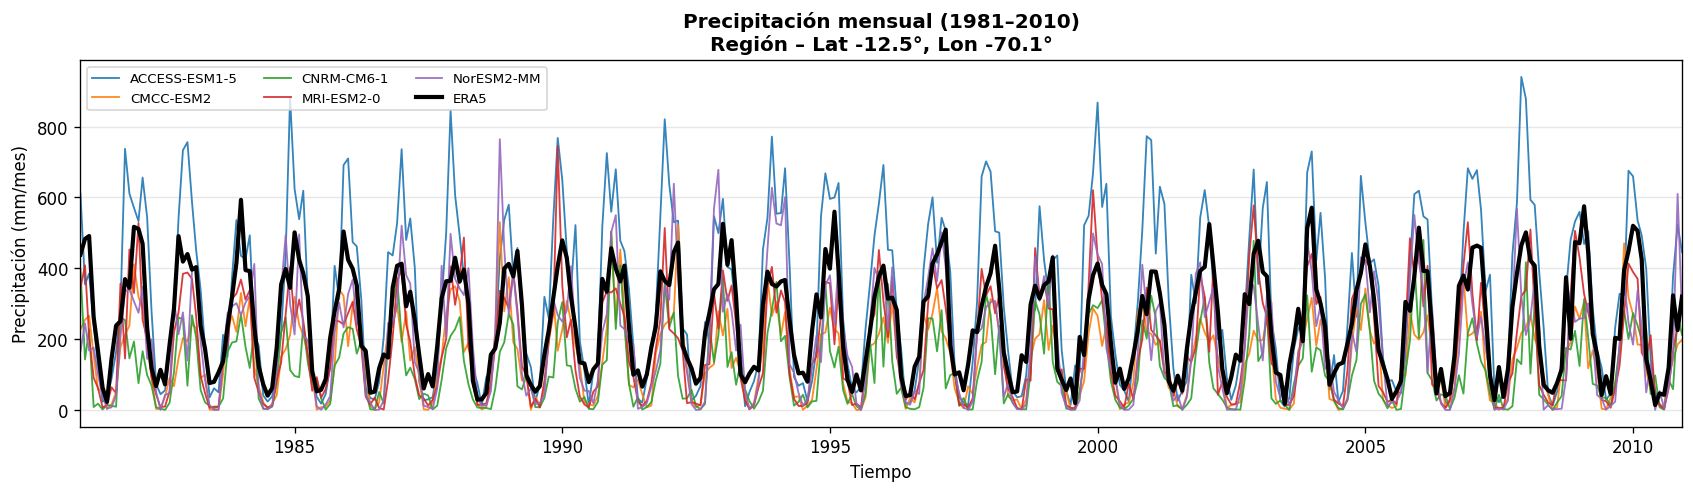

In [ ]:
# Define una serie  en CMPI 6 y contrastarlo con el ERA 5 para ver los sesgos
#============================================================
# SERIE COMPLETA 1981–2010 EN (LAT=-6, LON=-80)
# COMPARAR 5 MODELOS vs ERA5  (ALINEACIÓN ROBUSTA + BUENA ESTÉTICA)
import matplotlib.dates as mdates

# ------------------------------------------------------------
# ERA5: SERIE TEMPORAL EN EL PUNTO
# ------------------------------------------------------------
pr_era5_point = (
    pr_era5_all
    .sel(valid_time=PERIODO_CLIM)
    .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
    .rename(valid_time="time")
    .squeeze()
)

# Clave mensual YYYYMM (datetime64)
era_ym = (pr_era5_point.time.dt.year * 100 +
          pr_era5_point.time.dt.month).astype(int)

pr_era5_point = (
    pr_era5_point
    .assign_coords(ym=("time", era_ym.values))
    .swap_dims({"time": "ym"})
    .drop_vars("time")
)


# ------------------------------------------------------------
# CMIP6: SERIES TEMPORALES EN EL PUNTO
# ------------------------------------------------------------
series_cmip = {}

for modelo, pr in pr_por_modelo.items():

    s = (
        pr.sel(time=PERIODO_CLIM)
          .sel(lat=LAT_PTO, lon=LON_PTO, method="nearest")
    )

    s = squeeze_cmip_da(s)

    # Clave mensual YYYYMM (cftime compatible)
    cmip_ym = (s.time.dt.year * 100 +
               s.time.dt.month).astype(int)

    s = (
        s.assign_coords(ym=("time", cmip_ym.values))
         .swap_dims({"time": "ym"})
         .drop_vars("time")
    )

    series_cmip[modelo] = s


# ------------------------------------------------------------
# INTERSECCIÓN COMÚN DE MESES
# ------------------------------------------------------------
common_ym = set(pr_era5_point.ym.values.tolist())

for s in series_cmip.values():
    common_ym = common_ym.intersection(set(s.ym.values.tolist()))

common_ym = np.array(sorted(common_ym))

print("Meses comunes:", len(common_ym))
print("Inicio:", common_ym[0], "Fin:", common_ym[-1])


# ------------------------------------------------------------
# RECORTE FINAL
# ------------------------------------------------------------
pr_era5_aligned = pr_era5_point.sel(ym=common_ym)
series_cmip_aligned = {
    m: s.sel(ym=common_ym) for m, s in series_cmip.items()
}


# ------------------------------------------------------------
# GRÁFICO FINAL (PRESENTACIÓN MEJORADA)
# ------------------------------------------------------------

# Eje temporal bonito
time_plot = pd.to_datetime(common_ym.astype(str), format="%Y%m")

plt.figure(figsize=(14, 4), constrained_layout=True)

# Modelos CMIP6
for modelo, serie in series_cmip_aligned.items():
    plt.plot(
        time_plot,
        serie.values,
        lw=1.1,
        alpha=0.9,
        label=modelo
    )

# ERA5 destacado
plt.plot(
    time_plot,
    pr_era5_aligned.values,
    color="black",
    lw=2.5,
    label="ERA5",
    zorder=5
)

# Título
plt.title(
    f"Precipitación mensual (1981–2010)\n"
    f"Región – Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)

plt.xlabel("Tiempo")
plt.ylabel("Precipitación (mm/mes)")

# ---- AJUSTES CLAVE DEL EJE X ----
plt.margins(x=0)
plt.xlim(time_plot[0], time_plot[-1])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5)) # cada 5 años
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Grid solo horizontal (más limpio)
# Se evidencia una sobreestimacion de los modelos con el ERA5
ax.grid(axis="y", alpha=0.3)
ax.grid(axis="x", alpha=0)

plt.legend(ncol=3, fontsize=8)
plt.show()

In [ ]:
# ============================================================
# 4) LINEAR SCALING (LS) ESPACIAL POR MES: CMIP6 -> ERA5
#     Periodo base: 1981-01 a 2010-12
#     Variable: pr (mm/mes)
#     Resultado: FACTORES y PR_CORR en memoria
# ============================================================
# Se uso el metodo de calibracion: Linear Scaling (hacer la diferencia del
# periodo historico)

import numpy as np
import xarray as xr
import pandas as pd

PERIODO_CLIM = slice("1981-01", "2010-12")

# ------------------------------------------------------------
# 4.1 Dominio con BUFFER (mejora visualización)
# ------------------------------------------------------------
def expand_domain(dominio, dlat=2.0, dlon=2.0):
    return dict(
        lat=slice(dominio["lat"].start - dlat,
                  dominio["lat"].stop  + dlat),
        lon=slice(dominio["lon"].start - dlon,
                  dominio["lon"].stop  + dlon),
    )

DOMINIO_BUF = expand_domain(DOMINIO, dlat=2.0, dlon=2.0)

In [ ]:
# ------------------------------------------------------------
# 4.2 ERA5: dominio + periodo + grilla objetivo
# ------------------------------------------------------------
era_domain = dict(
    latitude=slice(DOMINIO_BUF["lat"].start, DOMINIO_BUF["lat"].stop), # Se aplica un buffer 2
    longitude=slice(DOMINIO_BUF["lon"].start, DOMINIO_BUF["lon"].stop),
)

pr_era5_dom = (
    pr_era5_all
    .sel(valid_time=PERIODO_CLIM)
    .sel(**era_domain)
    .sortby("latitude")
    .sortby("longitude")
)

era_lat = pr_era5_dom.latitude
era_lon = pr_era5_dom.longitude

# Climatología ERA5 mensual (12 meses)
clim_era5 = (
    pr_era5_dom
    .groupby("valid_time.month")
    .mean("valid_time", skipna=True)
)
clim_era5.name = "pr_clim_era5"
clim_era5.attrs["units"] = "mm/mes"

print("ERA5 listo | climatología:", clim_era5.shape)

ERA5 listo | climatología: (12, 31, 53)


In [ ]:
# ------------------------------------------------------------
# 4.3 Funciones
# ------------------------------------------------------------
def cmip_to_era_grid(pr_cmip_mm_mon, era_lat, era_lon, dominio, periodo):
    """
    Interpola CMIP6 (time, lat, lon) directamente a la grilla ERA5.
    Devuelve DataArray con dims:
    (valid_time, latitude, longitude)
    """

    da = (
        pr_cmip_mm_mon
        .sel(time=periodo)
        .sel(**dominio)
    )

    da = squeeze_cmip_da(da)

    # interp requiere coords monótonas
    da = da.sortby("lat").sortby("lon")

    # Se aplica una interpolacion

    # Interpolación bilinear (ERA5 define la grilla)
    da_i = da.interp(lat=era_lat, lon=era_lon, method="linear")

    # Solo renombrar el tiempo
    da_i = da_i.rename({"time": "valid_time"})

    # Limpieza: eliminar coords heredadas CMIP6
    da_i = da_i.drop_vars(
        [c for c in da_i.coords
         if c not in {"valid_time", "latitude", "longitude"}],
        errors="ignore"
    )

    da_i.attrs["units"] = "mm/mes"
    return da_i


def monthly_climatology(da):
    """Climatología mensual."""
    return da.groupby("valid_time.month").mean("valid_time", skipna=True)


def ls_factor_ratio(clim_ref, clim_mod, eps=1e-6, fmin=0.0, fmax=10.0):
    """
    Linear Scaling multiplicativo (precipitación):
    factor = ERA5 / MODELO
    """
    clim_mod_safe = xr.where(clim_mod < eps, np.nan, clim_mod)
    factor = clim_ref / clim_mod_safe
    factor = factor.clip(min=fmin, max=fmax)
    factor.name = "ls_factor"
    factor.attrs["units"] = "1"
    return factor

In [ ]:
# ------------------------------------------------------------
# 4.4 Cálculo LS por MODELO
# ------------------------------------------------------------
# Calculo del Fcator de correccion que es el sego entro lo observado y modelado
# FC por grilla y por modelo

FACTORES = {}   # (month, latitude, longitude)
PR_CORR  = {}   # (valid_time, latitude, longitude)

for modelo, pr_cmip in pr_por_modelo.items():
    print(f"\n--- Procesando {modelo} ---")

    # 1) CMIP → ERA5 grid (con buffer)
    pr_cmip_on_era = cmip_to_era_grid(
        pr_cmip,
        era_lat,
        era_lon,
        DOMINIO_BUF,
        PERIODO_CLIM
    )

    # 2) Climatología mensual del modelo
    clim_mod = monthly_climatology(pr_cmip_on_era)

    # 3) Factor LS mensual espacial
    factor = ls_factor_ratio(clim_era5, clim_mod)
    factor.attrs.update({
        "description": "Linear Scaling monthly spatial factor (ERA5 / MODEL)",
        "period_base": "1981-2010",
        "model": modelo,
        "variable": "pr"
    })
    FACTORES[modelo] = factor

    # 4) Aplicar corrección
    pr_corr = pr_cmip_on_era.groupby("valid_time.month") * factor
    pr_corr = pr_corr.drop_vars("month", errors="ignore")
    pr_corr.name = "pr_ls"
    pr_corr.attrs.update({
        "units": "mm/mes",
        "calibration": "Linear Scaling vs ERA5 (1981-2010)",
        "model": modelo
    })
    PR_CORR[modelo] = pr_corr

    print("✔ Factor y serie corregida en memoria")

print("\n✔ LS COMPLETADO")
print("Modelos en FACTORES:", list(FACTORES.keys()))
print("Modelos en PR_CORR :", list(PR_CORR.keys()))


--- Procesando ACCESS-ESM1-5 ---
✔ Factor y serie corregida en memoria

--- Procesando CMCC-ESM2 ---
✔ Factor y serie corregida en memoria

--- Procesando CNRM-CM6-1 ---
✔ Factor y serie corregida en memoria

--- Procesando MRI-ESM2-0 ---
✔ Factor y serie corregida en memoria

--- Procesando NorESM2-MM ---
✔ Factor y serie corregida en memoria

✔ LS COMPLETADO
Modelos en FACTORES: ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM']
Modelos en PR_CORR : ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM']


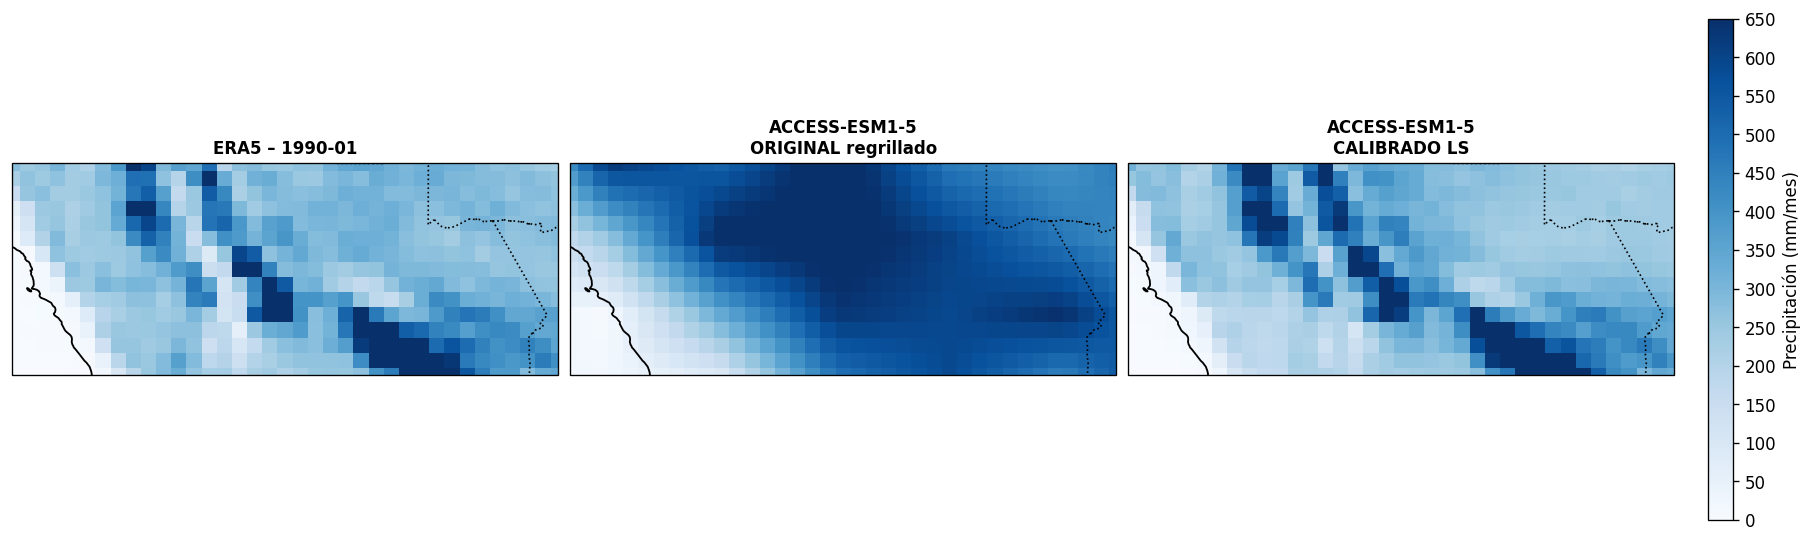

In [ ]:
# ============================================================
# COMPARACIÓN 1x3: ERA5 | CMIP regrillado | CMIP calibrado
# Genera una grafica para ver como ha mejorado, usando un modelo
modelo = "ACCESS-ESM1-5"
fecha  = FECHA_EJEMPLO

# --- Datos ---
era = (
    pr_era5_dom
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .rename({"latitude": "lat", "longitude": "lon"})
)

cmip_orig = (
    cmip_to_era_grid(
        pr_por_modelo[modelo],
        era_lat, era_lon,
        DOMINIO_BUF, PERIODO_CLIM
    )
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .sel(
        latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
        longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop),
    )
    .rename({"latitude": "lat", "longitude": "lon"})
)

cmip_corr = (
    PR_CORR[modelo]
    .sel(valid_time=fecha)
    .squeeze("valid_time")
    .sel(
        latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
        longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop),
    )
    .rename({"latitude": "lat", "longitude": "lon"})
)

# --- Parámetros comunes ---
vmin, vmax = 0, 650
extent = [
    DOMINIO["lon"].start, DOMINIO["lon"].stop,
    DOMINIO["lat"].start, DOMINIO["lat"].stop,
]

# ============================================================
# FIGURA 1x3
# ============================================================
fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 5),
    subplot_kw={"projection": proj},
    constrained_layout=True
)

campos = [era, cmip_orig, cmip_corr]
titulos = [
    f"ERA5 – {fecha}",
    f"{modelo}\nORIGINAL regrillado",
    f"{modelo}\nCALIBRADO LS"
]

for ax, da, titulo in zip(axes, campos, titulos):
    ax.set_extent(extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.1)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da.lon, da.lat, da.values,
        cmap="Blues",
        shading="auto",
        transform=proj,
        vmin=vmin, vmax=vmax
    )

    ax.set_title(titulo, fontweight="bold", fontsize=10)

# --- Barra de colores común ---
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="vertical",
    shrink=0.85,
    pad=0.02
)
cbar.set_label("Precipitación (mm/mes)")
cbar.set_ticks(np.arange(0, 651, 50))

plt.show()


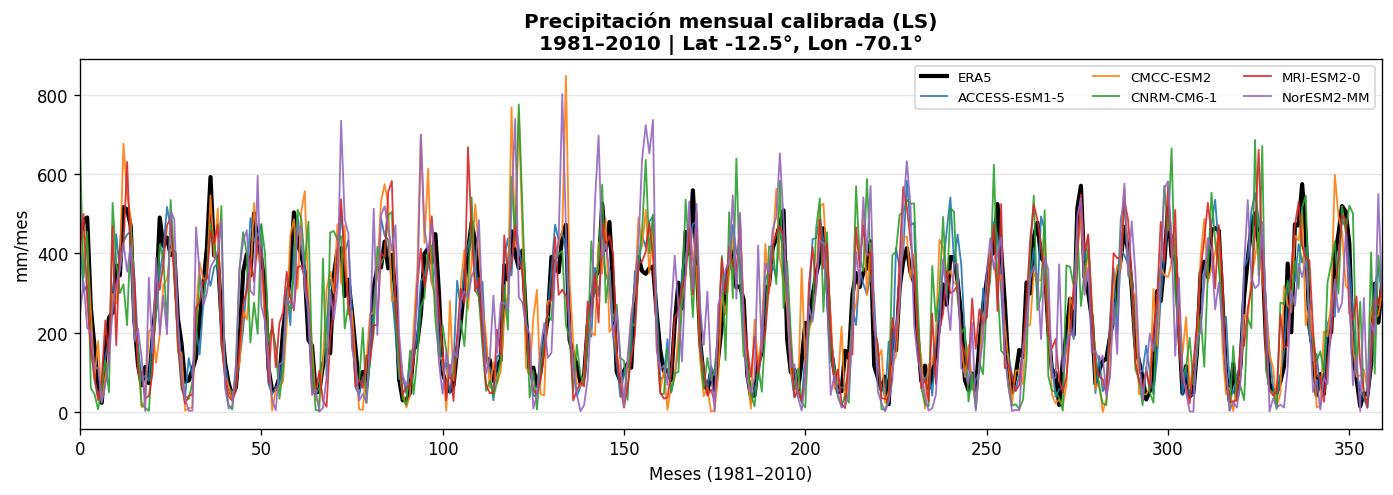

In [ ]:
# ============================================================
# SERIE 1981–2010 , Modelo regrillado -Modelo calibrado (LS)-Era5
# ============================================================
# Se realiza un plot para ver la calibracion del modelo
plt.figure(figsize=(14, 4))

# ERA5 (referencia)
era = (
    pr_era5_dom
    .sel(valid_time=PERIODO_CLIM)
    .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
    .values
)

x = np.arange(len(era))  # eje X simple

plt.plot(x, era, "k", lw=2.5, label="ERA5")

# Modelos calibrados
for modelo, pr_corr in PR_CORR.items():
    serie = (
        pr_corr
        .sel(valid_time=PERIODO_CLIM)
        .sel(latitude=LAT_PTO, longitude=LON_PTO, method="nearest")
        .values
    )
    plt.plot(x, serie, lw=1.1, alpha=0.9, label=modelo)

# Etiquetas
plt.title(
    f"Precipitación mensual calibrada (LS)\n"
    f"1981–2010 | Lat {LAT_PTO}°, Lon {LON_PTO}°",
    fontweight="bold"
)
plt.ylabel("mm/mes")
plt.xlabel("Meses (1981–2010)")

plt.legend(ncol=3, fontsize=8)
plt.grid(axis="y", alpha=0.3)
plt.margins(x=0)

plt.show()


✅Calibración por Linear Scaling (LS)

Se implementó exitosamente una calibración espacial y mensual por Linear Scaling (LS) de la precipitación mensual (mm/mes) de cinco modelos CMIP6 respecto a ERA5, usando el período 1981–2010 como climatología de referencia.

🔹 Metodología

Los campos CMIP6 fueron regrillados a la grilla ERA5.

Se calcularon factores mensuales espaciales LS (ERA5 / modelo) por modelo.

Los factores se aplicaron a las series originales, obteniendo series calibradas.

Todo el procesamiento se realizó en linea, sin generar archivos intermedios.

🔹 Resultados principales

✔️ Lo que sí logra el LS

Reduce significativamente el sesgo medio mensual de precipitación.

Ajusta correctamente la climatología mensual (12 meses) respecto a ERA5.

Mantiene la estructura espacial y temporal de cada modelo.

Permite una comparación consistente ERA5 vs modelos calibrados.

Es robusto, estable y conservador, adecuado para análisis climáticos regionales.

⚠️ Lo que no corrige el LS (esperado)

No ajusta bien los extremos mensuales (picos de precipitación).

No corrige percentiles altos (P95, P99).

No modifica la distribución de la precipitación.

👉 Este comportamiento es normal y consistente con la teoría del método LS, ya que utiliza un factor multiplicativo único por mes, sin alterar la variabilidad interna del modelo.

🔹 Interpretación científica

El LS corrige el sesgo sistemático, pero no la física de los eventos extremos.

Las discrepancias en meses muy lluviosos no indican un error, sino una limitación inherente del método.

El buen ajuste de la media mensual confirma que la calibración fue correctamente implementada.

In [ ]:
#Lectura de los escenarios futuros del CMPI6
import intake
import xarray as xr

# ============================================================
# CATÁLOGO CMIP6
# ============================================================
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
cat = intake.open_esm_datastore(cat_url)

# ============================================================
# MODELOS Y MIEMBROS
# ============================================================
MODELOS = {
    "ACCESS-ESM1-5": "r1i1p1f1",
    "CMCC-ESM2":     "r1i1p1f1",
    "CNRM-CM6-1":    "r1i1p1f2",
    "MRI-ESM2-0":    "r1i1p1f1",
    "NorESM2-MM":    "r1i1p1f1"
}

# ============================================================
# ESCENARIOS SSP
# ============================================================
SSP_LIST = ["ssp126", "ssp245", "ssp370", "ssp585"]

# ============================================================
# PERIODO FUTURO
# ============================================================
#PERIODO_FUTURO = slice("2036-01", "2065-12") # Define un periodo futuro
#cada 30 y
PERIODO_FUTURO = slice("2036-01", "2095-12")
# ============================================================
# CONTENEDORES
# ============================================================
datasets_futuro = {}
pr_futuro = {}   # pr_futuro[ssp][modelo]

# ============================================================
# BUCLE SSP × MODELO
# ============================================================
for ssp in SSP_LIST:
    print(f"\n==============================")
    print(f"  ESCENARIO {ssp.upper()}")
    print(f"==============================")

    pr_futuro[ssp] = {}

    for modelo, member in MODELOS.items():
        print(f"\nAbriendo {modelo} ({member})...")

        cat_tmp = cat.search(
            activity_id="ScenarioMIP",
            source_id=modelo,
            experiment_id=ssp,
            table_id="Amon",
            variable_id="pr",
            member_id=member
        )

        if len(cat_tmp.df) == 0:
            print(f"  ❌ {modelo}: no disponible para {ssp}")
            continue

        ds_dict = cat_tmp.to_dataset_dict(
            zarr_kwargs={"consolidated": False},
            storage_options={"token": "anon"},
            xarray_open_kwargs={"use_cftime": True}
        )

        ds = list(ds_dict.values())[0]

        # --------------------------------------------------------
        # Arreglar longitudes (0–360 → -180–180)
        # --------------------------------------------------------
        ds = fix_lon_cmip(ds)

        # --------------------------------------------------------
        # Seleccionar periodo futuro
        # --------------------------------------------------------
        ds = ds.sel(time=PERIODO_FUTURO)

        if ds.time.size == 0:
            print(f"  ⚠️ {modelo}: sin datos en 2036–2065")
            continue

        # --------------------------------------------------------
        # Conversión pr → mm/mes
        # --------------------------------------------------------
        days_in_month = ds.time.dt.days_in_month
        pr_modelo = ds["pr"] * 86400 * days_in_month
        pr_modelo.attrs["units"] = "mm/mes"
        pr_modelo.attrs["long_name"] = "Precipitación mensual"

        pr_futuro[ssp][modelo] = pr_modelo
        datasets_futuro[(ssp, modelo)] = ds

        print(f"  ✅ {modelo} cargado | meses = {pr_modelo.time.size}")


  ESCENARIO SSP126

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado | meses = 720

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 720

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 720

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 720

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 720

  ESCENARIO SSP245

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...
  ❌ ACCESS-ESM1-5: no disponible para ssp245

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 720

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 720

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 720

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 720

  ESCENARIO SSP370

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...
  ❌ ACCESS-ESM1-5: no disponible para ssp370

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 720

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 720

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 720

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 720

  ESCENARIO SSP585

Abriendo ACCESS-ESM1-5 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ ACCESS-ESM1-5 cargado | meses = 720

Abriendo CMCC-ESM2 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CMCC-ESM2 cargado | meses = 720

Abriendo CNRM-CM6-1 (r1i1p1f2)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ CNRM-CM6-1 cargado | meses = 720

Abriendo MRI-ESM2-0 (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ MRI-ESM2-0 cargado | meses = 720

Abriendo NorESM2-MM (r1i1p1f1)...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  ✅ NorESM2-MM cargado | meses = 720


In [ ]:
# ============================================================
# PASO 1) CMIP6 FUTURO -> GRILLA ERA5 (para cada SSP × modelo)
# ============================================================
# Los datos de los escenarios llevarlos a las grillas de ERA5
def cmip_future_to_era_grid(pr_cmip_mm_mon, era_lat, era_lon, dominio):
    """
    Interpola CMIP6 futuro (time, lat, lon) a la grilla ERA5.
    Devuelve DataArray con dims: (valid_time, latitude, longitude)
    """
    da = pr_cmip_mm_mon.sel(**dominio)
    da = squeeze_cmip_da(da)
    da = da.sortby("lat").sortby("lon")

    da_i = da.interp(lat=era_lat, lon=era_lon, method="linear")
    da_i = da_i.rename({"time": "valid_time"})

    # Asegurar nombres (por si interp deja lat/lon)
    if "lat" in da_i.dims:
        da_i = da_i.rename({"lat": "latitude"})
    if "lon" in da_i.dims:
        da_i = da_i.rename({"lon": "longitude"})

    da_i.attrs["units"] = "mm/mes"
    return da_i


PR_FUT_ON_ERA = {}   # PR_FUT_ON_ERA[ssp][modelo] => (valid_time, latitude, longitude)

for ssp in SSP_LIST:
    PR_FUT_ON_ERA[ssp] = {}
    for modelo, pr_da in pr_futuro[ssp].items():
        pr_on_era = cmip_future_to_era_grid(pr_da, era_lat, era_lon, DOMINIO_BUF)
        PR_FUT_ON_ERA[ssp][modelo] = pr_on_era

print("✔ Futuro regrillado a ERA5 para:", {ssp: list(PR_FUT_ON_ERA[ssp].keys()) for ssp in SSP_LIST})


✔ Futuro regrillado a ERA5 para: {'ssp126': ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM'], 'ssp245': ['CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM'], 'ssp370': ['CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM'], 'ssp585': ['ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-CM6-1', 'MRI-ESM2-0', 'NorESM2-MM']}


In [ ]:
# ============================================================
# PASO 2) APLICAR LS AL FUTURO (factor mensual del histórico)
# ============================================================
# Aplicar los FC basandonse en los historicos para el periodo futuro
PR_FUT_CORR = {}   # PR_FUT_CORR[ssp][modelo]

for ssp in SSP_LIST:
    PR_FUT_CORR[ssp] = {}
    for modelo, pr_on_era in PR_FUT_ON_ERA[ssp].items():

        if modelo not in FACTORES:
            print(f"⚠️ No hay FACTOR LS para {modelo} (se salta)")
            continue

        factor = FACTORES[modelo]  # dims: (month, latitude, longitude)

        pr_corr = pr_on_era.groupby("valid_time.month") * factor #Factor ya se calculo de dato historicos
        pr_corr = pr_corr.drop_vars("month", errors="ignore")
        pr_corr.name = "pr_ls_future"
        pr_corr.attrs.update({
            "units": "mm/mes",
            "calibration": "Linear Scaling vs ERA5 (1981-2010)",
            "model": modelo,
            "scenario": ssp
        })

        PR_FUT_CORR[ssp][modelo] = pr_corr

print("✔ Futuro calibrado con LS listo.")


✔ Futuro calibrado con LS listo.


In [ ]:
# ============================================================
# PASO 3) EXTRAER SERIES EN EL PUNTO (LAT_PTO, LON_PTO)
# ============================================================
# Del punto defino se calcula el ciclo anual para ver si calculo correctamente
def point_series_era_grid(da, lat_pt, lon_pt):
    """Extrae serie temporal en punto desde DataArray en grilla ERA5."""
    return (
        da.sel(latitude=lat_pt, longitude=lon_pt, method="nearest")
          .squeeze()
    )

# Histórico calibrado (ya está en PR_CORR)
SER_HIST_CORR = {}
for modelo, pr_corr in PR_CORR.items():
    SER_HIST_CORR[modelo] = point_series_era_grid(pr_corr, LAT_PTO, LON_PTO)

# Futuro calibrado
SER_FUT_CORR = {}  # SER_FUT_CORR[ssp][modelo]
for ssp in SSP_LIST:
    SER_FUT_CORR[ssp] = {}
    for modelo, pr_corr_fut in PR_FUT_CORR[ssp].items():
        SER_FUT_CORR[ssp][modelo] = point_series_era_grid(pr_corr_fut, LAT_PTO, LON_PTO)

print("✔ Series en punto listas.")


✔ Series en punto listas.


In [ ]:
# ============================================================
# PASO 4) CICLO ANUAL (12 meses) y COMPARACIÓN
# ============================================================

def annual_cycle(serie, time_name="valid_time"):
    """Devuelve climatología mensual (1..12) de una serie temporal."""
    return serie.groupby(f"{time_name}.month").mean(time_name, skipna=True)

# --- Histórico (1981-2010): ciclo anual por modelo (calibrado) ---# Periodo base
AC_HIST = {}
for modelo, ser in SER_HIST_CORR.items():
    # asegurar nombre de tiempo
    tname = "valid_time" if "valid_time" in ser.dims else ("time" if "time" in ser.dims else None)
    if tname is None:
        raise ValueError(f"No se reconoce dimensión tiempo en HIST {modelo}: {ser.dims}")

    ser_sub = ser.sel({tname: PERIODO_CLIM})
    AC_HIST[modelo] = annual_cycle(ser_sub, time_name=tname) # Modelo de referencia

# --- Futuro (2036-2065): ciclo anual por escenario y modelo (calibrado) ---
AC_FUT = {}
for ssp in SSP_LIST:
    AC_FUT[ssp] = {}
    for modelo, ser in SER_FUT_CORR[ssp].items():
        tname = "valid_time" if "valid_time" in ser.dims else ("time" if "time" in ser.dims else None)
        if tname is None:
            raise ValueError(f"No se reconoce dimensión tiempo en FUT {ssp}-{modelo}: {ser.dims}")

        ser_sub = ser.sel({tname: PERIODO_FUTURO})
        AC_FUT[ssp][modelo] = annual_cycle(ser_sub, time_name=tname)

print("✔ Ciclos anuales calculados.")


✔ Ciclos anuales calculados.


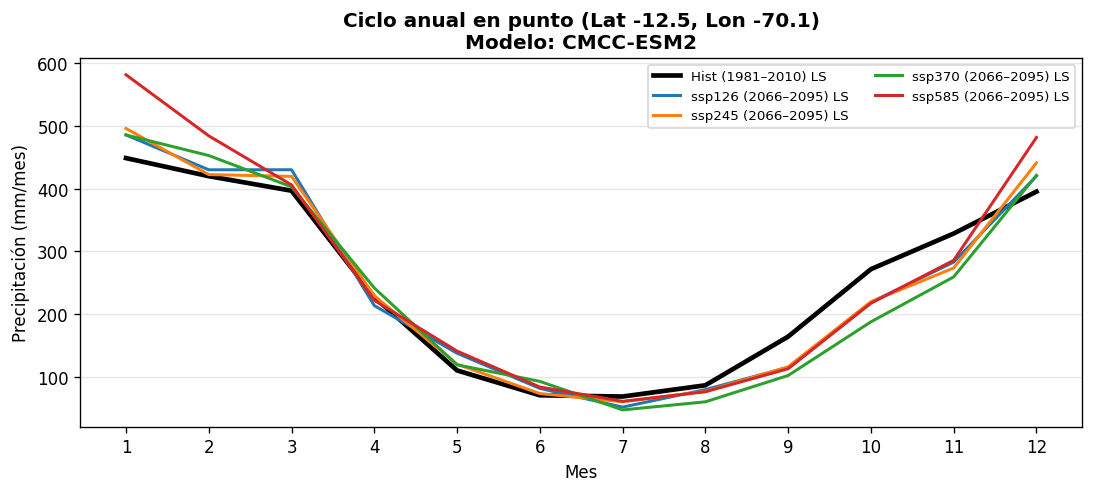

In [ ]:
# ============================================================
# PLOT: CICLO ANUAL HIST vs SSPs (para un modelo)
# ============================================================

modelo_plot = "CMCC-ESM2"
meses = np.arange(1, 13)

plt.figure(figsize=(9, 4), constrained_layout=True)

# Histórico calibrado
plt.plot(meses, AC_HIST[modelo_plot].values, lw=2.8, color="black", label="Hist (1981–2010) LS")

# Futuros calibrados
for ssp in SSP_LIST:
    if modelo_plot in AC_FUT[ssp]:
        #plt.plot(meses, AC_FUT[ssp][modelo_plot].values, lw=1.8, label=f"{ssp} (2036–2065) LS")
        plt.plot(meses, AC_FUT[ssp][modelo_plot].values, lw=1.8, label=f"{ssp} (2066–2095) LS")

plt.xticks(meses)
plt.xlabel("Mes")
plt.ylabel("Precipitación (mm/mes)")
plt.title(f"Ciclo anual en punto (Lat {LAT_PTO}, Lon {LON_PTO})\nModelo: {modelo_plot}", fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.show()


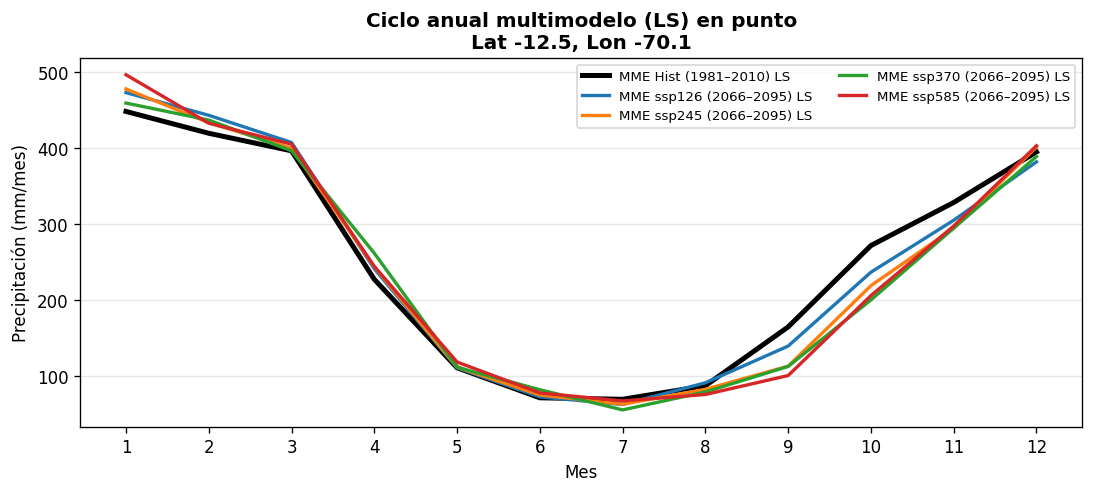

In [ ]:
# ============================================================
# EXTRA: PROMEDIO MULTIMODELO (ciclo anual)
# ============================================================
#Promedio de los modelos (5) seleccionados
def mean_annual_cycle(dic_ac):
    """Promedia ciclos anuales (dict modelo -> AC[month])."""
    arr = xr.concat(list(dic_ac.values()), dim="model").mean("model", skipna=True)
    return arr

AC_HIST_MME = mean_annual_cycle(AC_HIST)

AC_FUT_MME = {}
for ssp in SSP_LIST:
    if len(AC_FUT[ssp]) > 0:
        AC_FUT_MME[ssp] = mean_annual_cycle(AC_FUT[ssp])

meses = np.arange(1, 13)
plt.figure(figsize=(9, 4), constrained_layout=True)

plt.plot(meses, AC_HIST_MME.values, lw=3.0, color="black", label="MME Hist (1981–2010) LS")

for ssp in SSP_LIST:
    if ssp in AC_FUT_MME:
        #plt.plot(meses, AC_FUT_MME[ssp].values, lw=2.0, label=f"MME {ssp} (2036–2065) LS")
        plt.plot(meses, AC_FUT_MME[ssp].values, lw=2.0, label=f"MME {ssp} (2066–2095) LS")

plt.xticks(meses)
plt.xlabel("Mes")
plt.ylabel("Precipitación (mm/mes)")
plt.title(f"Ciclo anual multimodelo (LS) en punto\nLat {LAT_PTO}, Lon {LON_PTO}", fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.show()


In [ ]:
#CAMBIO PORCENTUAL DE LA PRECIPITACIÓN

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

proj = ccrs.PlateCarree()

# ============================================================
# 1) CLIMATOLOGÍA ANUAL (por modelo)
# ============================================================

CLIM_HIST_ANUAL = {
    m: PR_CORR[m].sel(valid_time=PERIODO_CLIM).mean("valid_time", skipna=True)
    for m in PR_CORR
}

CLIM_FUT_ANUAL = {}
for ssp in SSP_LIST:
    CLIM_FUT_ANUAL[ssp] = {
        m: PR_FUT_CORR[ssp][m]
           .sel(valid_time=PERIODO_FUTURO)
           .mean("valid_time", skipna=True)
        for m in PR_FUT_CORR[ssp]
    }

In [ ]:
# ============================================================
# 2) PROMEDIO MULTIMODELO (MME)
# ============================================================

def multimodel_mean(dic_models):
    return xr.concat(list(dic_models.values()), dim="model") \
             .mean("model", skipna=True)

MME_HIST = multimodel_mean(CLIM_HIST_ANUAL)

MME_FUT = {
    ssp: multimodel_mean(CLIM_FUT_ANUAL[ssp])
    for ssp in SSP_LIST
}

In [ ]:
# ============================================================
# 3) CAMBIO ANUAL RELATIVO (%) – FUTURO vs HIST
# ============================================================

DELTA_PCT = {}

eps = 1.0  # mm/mes → evita divisiones irreales

for ssp in SSP_LIST:
    delta = 100.0 * (MME_FUT[ssp] - MME_HIST) / xr.where(
        MME_HIST < eps, np.nan, MME_HIST
    )
    delta.name = f"delta_pr_pct_{ssp}"
    delta.attrs["units"] = "%"
    DELTA_PCT[ssp] = delta

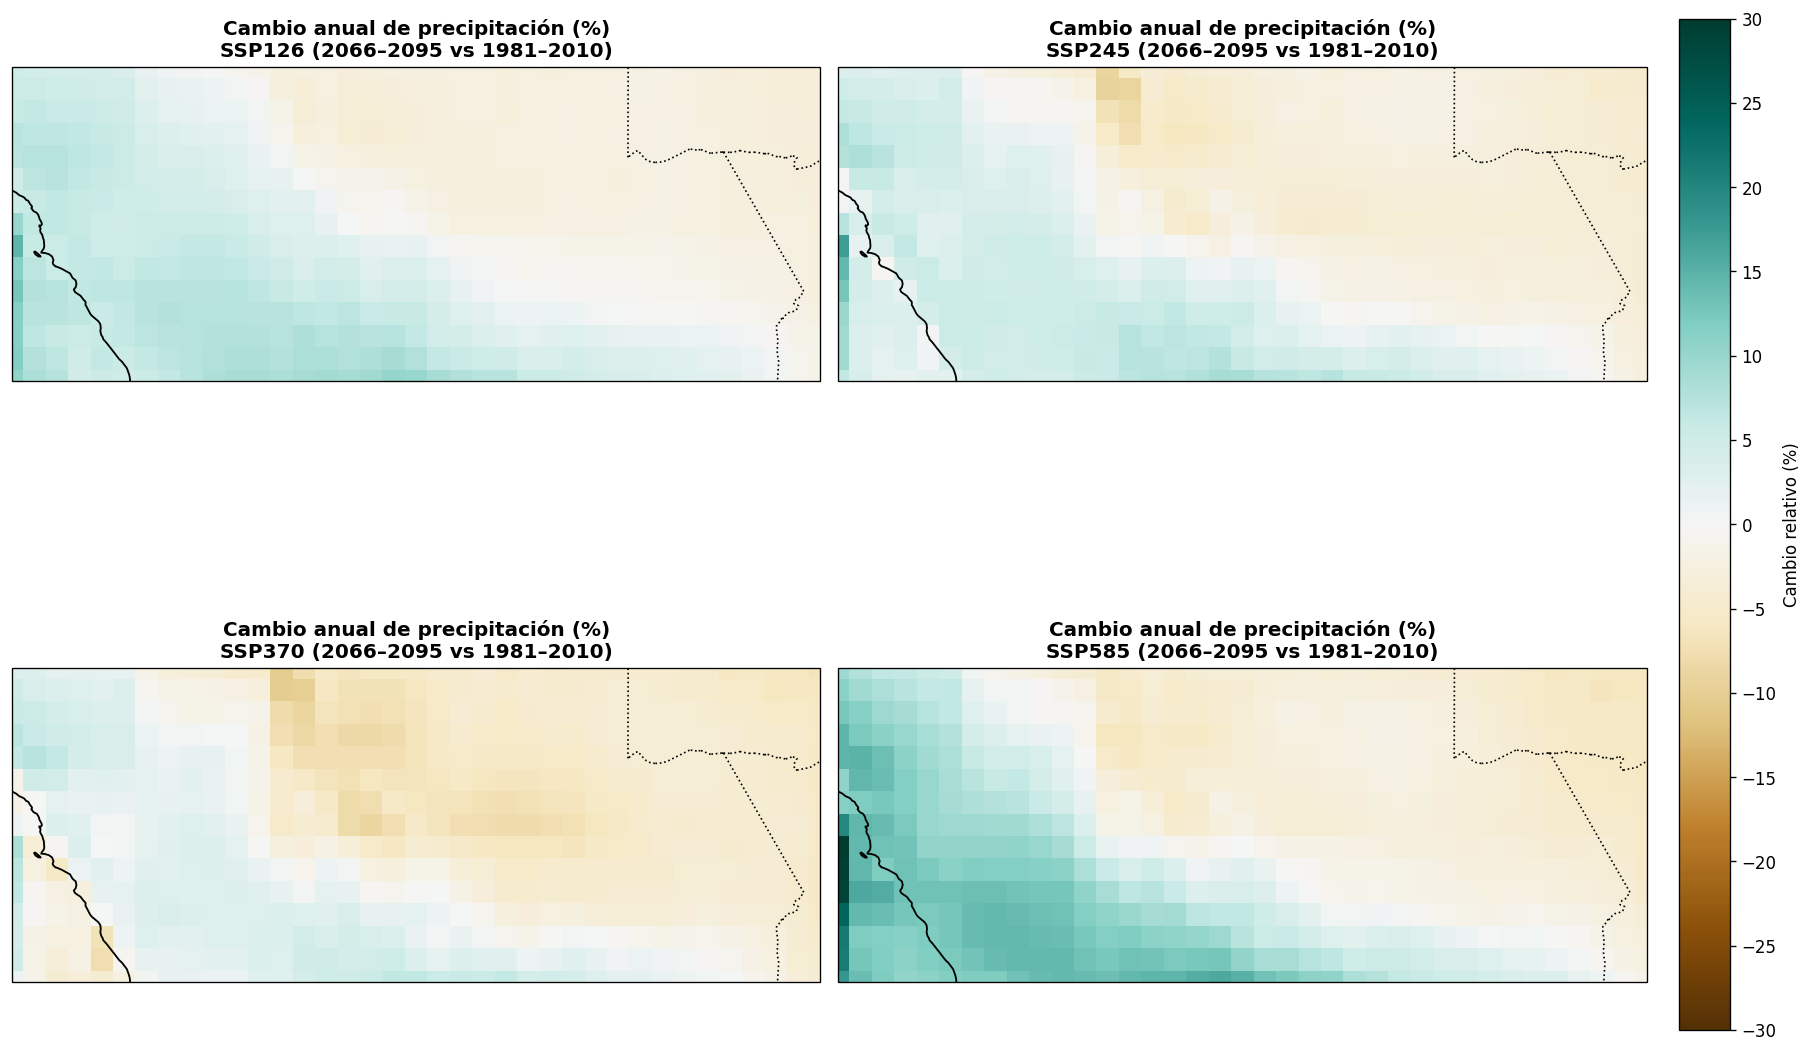

In [ ]:
# ============================================================
# 4) MAPAS POR ESCENARIO SSP
# ============================================================

vmax = 30.0
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(
    2, 2, figsize=(15, 10),
    subplot_kw={"projection": proj},
    constrained_layout=True
)

axes = axes.flatten()

for ax, ssp in zip(axes, SSP_LIST):

    da = DELTA_PCT[ssp].sel(
        latitude=slice(DOMINIO["lat"].start, DOMINIO["lat"].stop),
        longitude=slice(DOMINIO["lon"].start, DOMINIO["lon"].stop)
    )

    ax.set_extent(
        [DOMINIO["lon"].start, DOMINIO["lon"].stop,
         DOMINIO["lat"].start, DOMINIO["lat"].stop],
        crs=proj
    )

    ax.add_feature(cfeature.COASTLINE, linewidth=1.1)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    im = ax.pcolormesh(
        da.longitude,
        da.latitude,
        da.values,
        cmap="BrBG",
        norm=norm,
        shading="auto",
        transform=proj
    )

    ax.set_title(
        f"Cambio anual de precipitación (%)\n"
        #f"{ssp.upper()} (2036–2065 vs 1981–2010)",
        f"{ssp.upper()} (2066–2095 vs 1981–2010)",
        fontweight="bold"
    )

cbar = fig.colorbar(im, ax=axes, shrink=0.85, pad=0.02)
cbar.set_label("Cambio relativo (%)")
cbar.set_ticks(np.arange(-30, 31, 5))

plt.show()